# Tomographic reconstruction of a 2D phase space distribution

In [1]:
import sys
import importlib
import numpy as np
from matplotlib import pyplot as plt
import proplot as pplt
import seaborn as sns
from tqdm import tqdm, trange
from skimage.transform import radon
from skimage.transform import iradon
from scipy import interpolate

sys.path.append('/Users/austin/Research/') 
from scdist.tools import ap_utils
from scdist.tools import beam_analysis as ba
from scdist.tools import plotting as myplt
from scdist.tools import utils
from scdist.measurement.tomography import reconstruct as rec

In [2]:
pplt.rc['axes.grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'Mono_r'
pplt.rc['cmap.diverging'] = 'Vlag'
pplt.rc['figure.facecolor'] = 'white'

## Setup 

Create the distribution.

In [3]:
n = 300000
eps = 10.0 # [mm mrad]
alpha = -0.7
beta = 15.0

a = 2.0
X_true_n = np.vstack([
    np.random.normal(scale=[1.0, 1.0], loc=[0.0, 0.0], size=(n, 2)),
    np.random.normal(scale=0.6, loc=[+a, +a], size=(n//5, 2)),
    np.random.normal(scale=0.6, loc=[+a, -a], size=(n//5, 2)),
    np.random.normal(scale=0.6, loc=[-a, +a], size=(n//5, 2)),
    np.random.normal(scale=0.6, loc=[-a, -a], size=(n//5, 2)),
])
X_true_n /= np.sqrt(np.sqrt(np.linalg.det(np.cov(X_true_n.T))))
                    
A = np.sqrt(np.diag([eps, eps]))
V1 = ap_utils.V_matrix_2x2(alpha, beta)

X_true_n = utils.apply(A, X_true_n)
X_true = utils.apply(V1, X_true_n)

Define the reconstruction grid in normalized phase space.

In [4]:
n_bins = 75
limits_scale_fac = 1.7
xmax_rec_n = limits_scale_fac * np.sqrt(4.0 * eps)
xpmax_rec_n = limits_scale_fac * np.sqrt(4.0 * eps)
rec_grid_edges = [
    np.linspace(-xmax_rec_n, xmax_rec_n, n_bins + 1),
    np.linspace(-xpmax_rec_n, xpmax_rec_n, n_bins + 1),
]
rec_grid_centers = [
    utils.get_bin_centers(rec_grid_edges[0]),
    utils.get_bin_centers(rec_grid_edges[1]),
]

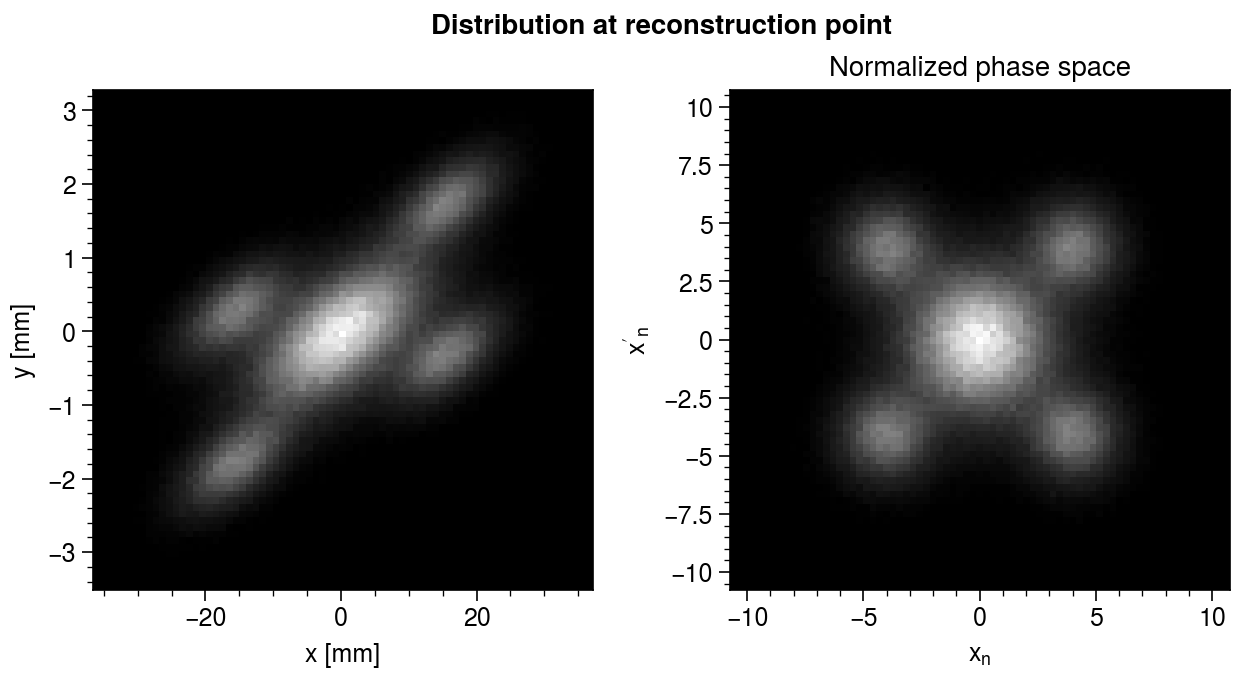

In [5]:
n_bins = 75
fig, axes = pplt.subplots(ncols=2, sharex=False, sharey=False)
axes[0].hist2d(X_true[:, 0], X_true[:, 1], bins=n_bins)
Z_true_n, _, _, _ = axes[1].hist2d(X_true_n[:, 0], X_true_n[:, 1], bins=rec_grid_edges)
axes[0].format(xlabel="x [mm]", ylabel="y [mm]", title='')
axes[1].format(xlabel=r"$x_n$", ylabel=r"$x'_n$", title='Normalized phase space')
axes.format(suptitle='Distribution at reconstruction point')
plt.show()

Simulate the measurements. We will scan the phase advance in a 180 degree range, then let $\alpha$ and $\beta$ take random values at the measurement location.

In [6]:
n_proj = 15
phase_advances = np.linspace(0.0, np.pi, n_proj, endpoint=False)
betas = np.random.uniform(55.0, 75.0, size=n_proj)
alphas = np.random.uniform(-1.5, +1.5, size=n_proj)
xmax_screen = 90.0 # [mm]
screen_xedges = np.linspace(-xmax_screen, xmax_screen, n_bins + 1)
screen_xcenters = 0.5 * (screen_xedges[:-1] + screen_xedges[1:])

In [7]:
tmats, projections = [], []
for k in trange(n_proj):
    # Compute the linear transfer matrix to the screen.
    V2 = ap_utils.V_matrix_2x2(alphas[k], betas[k])
    P = utils.rotation_matrix(phase_advances[k])
    M = np.linalg.multi_dot([V2, P, np.linalg.inv(V1)])
    tmats.append(np.linalg.multi_dot([M, V1]))
    # Transport the distribution to the screen.
    X_meas = utils.apply(M, X_true)    
    # Compute the projection on the screen.
    projection, _ = np.histogram(X_meas[:, 0], screen_xedges)
    projection / np.sum(projection)
    projections.append(projection)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.16s/it]


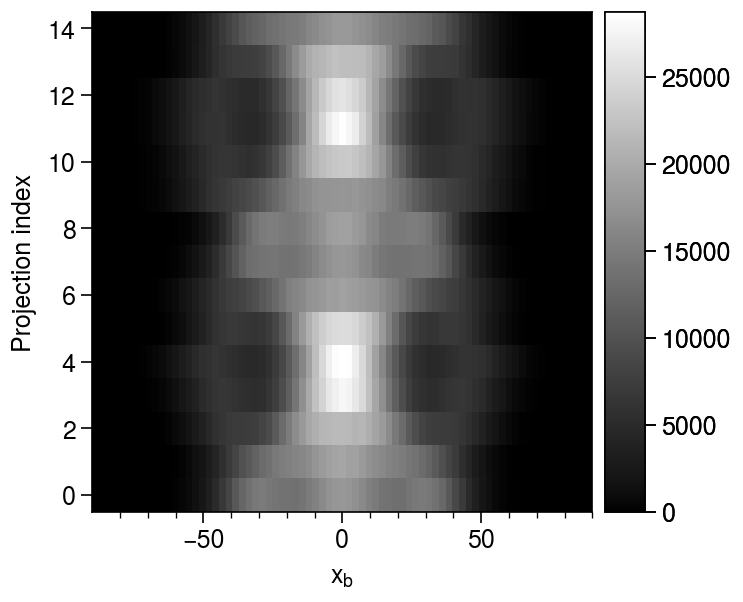

In [8]:
fig, ax = pplt.subplots()
ax.pcolormesh(screen_xcenters, np.arange(n_proj), projections, ec='None', colorbar=True)
ax.format(xlabel=r'$x_b$', ytickminor=False, ylabel='Projection index')
plt.show()

## Reconstruction 

In [9]:
xx_meas = screen_xcenters
xx_rec = rec_grid_centers[0]
proc_kws = dict(keep_positive=True)
Z_rec_n = rec.rec2D(projections, tmats, xx_meas, xx_rec, method='SART', proc_kws=proc_kws, iterations=5)

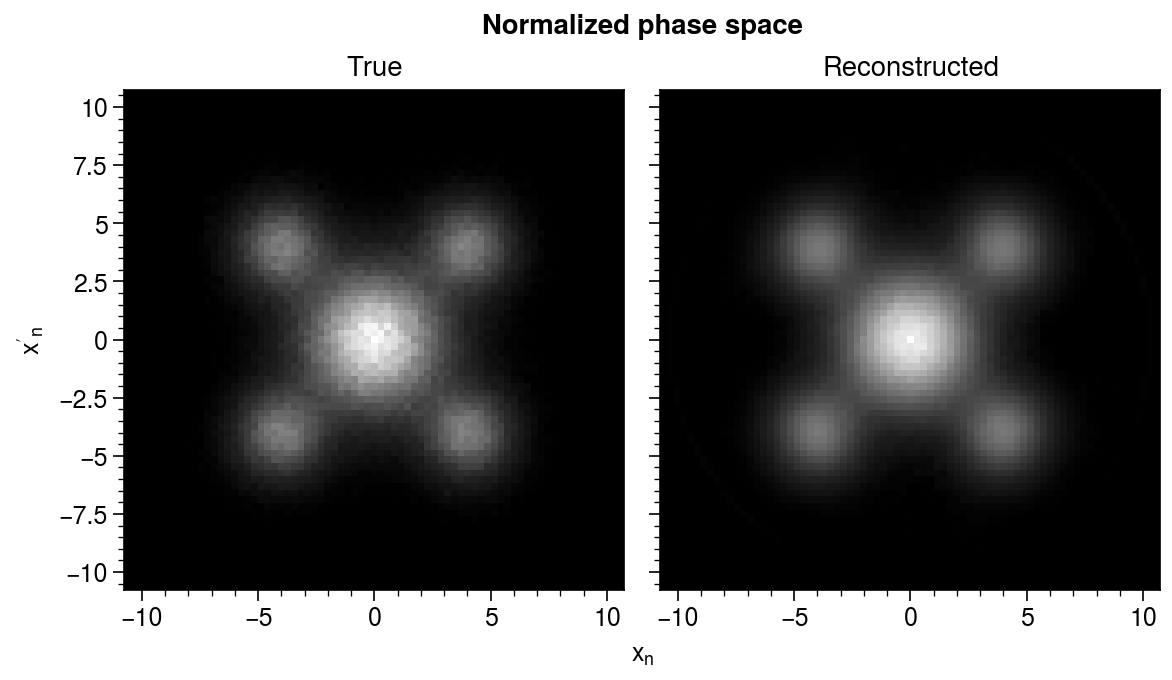

In [10]:
fig, axes = pplt.subplots(ncols=2)
plot_kws = dict(ec='None')
axes[0].pcolormesh(rec_grid_centers[0], rec_grid_centers[1], Z_true_n.T, **plot_kws)
axes[1].pcolormesh(rec_grid_centers[0], rec_grid_centers[1], Z_rec_n.T, **plot_kws)
axes[0].set_title('True')
axes[1].set_title('Reconstructed')
axes.format(xlabel=r'$x_n$', ylabel=r"$x'_n$", suptitle='Normalized phase space')
plt.show()

In [11]:
# Transform out of normalized phase space.
Z_rec, rec_grid_centers_ = rec.transform(Z_rec_n, V1, rec_grid_centers)
Z_rec = np.clip(Z_rec, 0.0, None) # some small nonzero elements
# Bin the true distribution on the grid.
rec_grid_edges_ = [
    rec.get_edges(rec_grid_centers_[0]),
    rec.get_edges(rec_grid_centers_[1]),
]
Z_true, _, _ = np.histogram2d(X_true[:, 0], X_true[:, 1], bins=rec_grid_edges_)

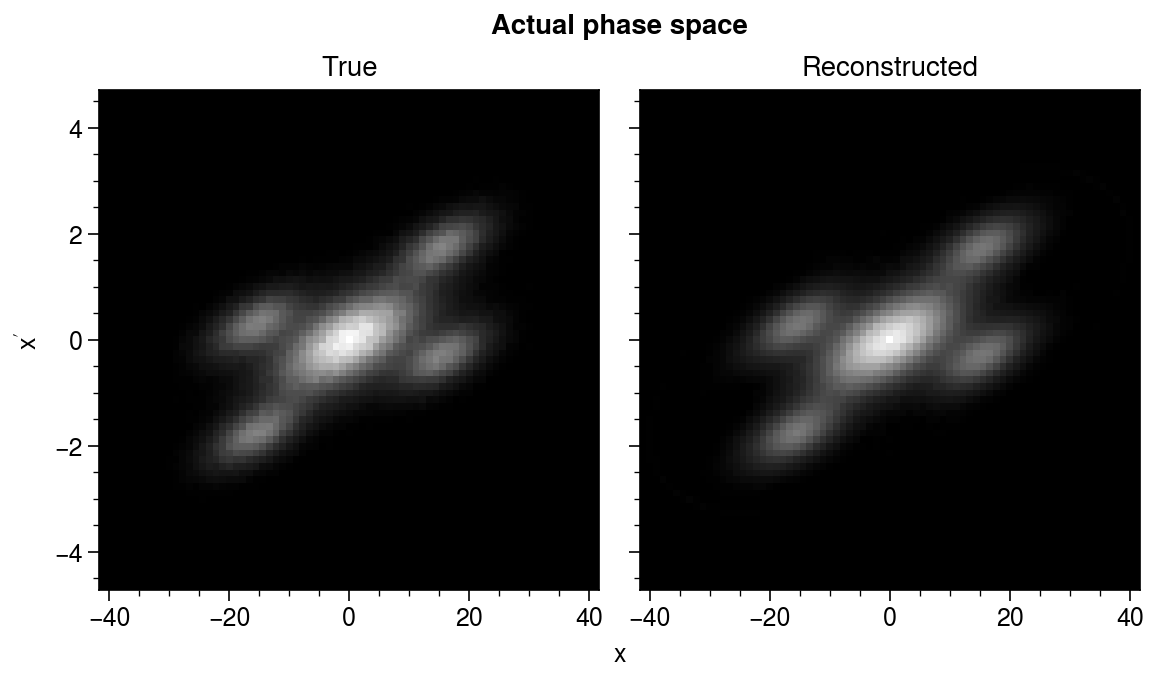

In [12]:
fig, axes = pplt.subplots(ncols=2)
axes[0].pcolormesh(rec_grid_centers_[0], rec_grid_centers_[1], Z_true.T, **plot_kws)
axes[1].pcolormesh(rec_grid_centers_[0], rec_grid_centers_[1], Z_rec.T, **plot_kws)
axes[0].set_title('True')
axes[1].set_title('Reconstructed')
axes.format(xlabel=r'$x$', ylabel=r"$x'$",
            suptitle='Actual phase space')
plt.show()